In [2]:
import pandas as pd
import numpy as np

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter, temporal_train_test_split
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.forecasting.base import BaseForecaster
from sktime.utils.validation.forecasting import check_X, check_y

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression

from tqdm import tqdm
import matplotlib.pyplot as plt

class ForecasterEvaluation:
    def __init__(self, results, managed_evaluator):
        self.results = results
        self.managed_evaluator = managed_evaluator


class ForecastResult:
    def __init__(self, fh, results, forecaster):
        self.fh = fh  # Forecast horizon used for the prediction
        self.results = results  # Forecasted values (typically a pandas Series)
        self.forecaster = forecaster  # Reference to the forecaster that produced this result


class ManagedForecaster:
    def __init__(self, forecaster_class, init_params=None, name=None):
        self.init_params = init_params or {}  # Parameters used to instantiate the model
        self.name = name or f"{forecaster_class.__name__}({self.init_params})"  # Unique identifier for this forecast instance
        self.forecaster = forecaster_class(**self.init_params)  # Instantiate forecaster
        self.is_fitted = False
        self.forecaster_evaluations = {}  # Changed from list to dict
        self.forecast_results = []
        self.fitted_params = None

    def fit(self, y, X=None, fh=None):
        if X is None or not self.forecaster.get_tag("X_inner_mtype"):
            self.forecaster.fit(y)
        else:
            self.forecaster.fit(y, X, fh)
        self.is_fitted = True
        try:
            self.fitted_params = self.forecaster.get_fitted_params()
        except Exception:
            self.fitted_params = None

    def evaluate(self, y, X=None, managed_evaluator=None):
        results = evaluate(
            forecaster=self.forecaster,
            y=y,
            X=X,
            cv=managed_evaluator.managed_cv.cv,
            strategy=managed_evaluator.strategy,
            scoring=[m.metric for m in managed_evaluator.scoring],
            error_score=managed_evaluator.error_score
        )
        evaluation = ForecasterEvaluation(results, managed_evaluator)
        self.forecaster_evaluations[managed_evaluator.managed_cv.name] = evaluation

    def predict(self, fh, X_test=None):
        if not self.is_fitted:
            raise RuntimeError(f"Forecaster '{self.name}' must be fitted before prediction.")
        if X_test is None or not self.forecaster.get_tag("X_inner_mtype"):
            results = self.forecaster.predict(fh)
        else:
            results = self.forecaster.predict(fh, X_test)
        forecast_result = ForecastResult(fh, results, self)
        self.forecast_results.append(forecast_result)
        return forecast_result


class ManagedCrossValidator:
    def __init__(self, splitter_class, init_params=None, name=None):
        self.splitter_class = splitter_class
        self.init_params = init_params or {}
        self.cv = splitter_class(**self.init_params)
        self.name = name or f"{splitter_class.__name__}({self.init_params})"


class ManagedMetric:
    def __init__(self, metric):
        self.metric = metric
        cls_name = metric.__class__.__name__
        params = metric.get_params()
        default_params = type(metric)().get_params()
        non_default = {k: v for k, v in params.items() if default_params.get(k) != v}
        if non_default:
            param_str = ", ".join(f"{k}={v}" for k, v in non_default.items())
            self.name = f"{cls_name}({param_str})"
        else:
            self.name = cls_name


class ManagedEvaluator:
    def __init__(self, managed_cv, strategy="refit", scoring=None, error_score="raise"):
        self.managed_cv = managed_cv
        self.strategy = strategy
        if isinstance(scoring, ManagedMetric):
            self.scoring = [scoring]
        elif isinstance(scoring, list) and all(isinstance(s, ManagedMetric) for s in scoring):
            self.scoring = scoring
        else:
            raise ValueError("scoring must be a ManagedMetric or a list of ManagedMetric objects")
        self.error_score = error_score


class ForecastManager:

    def __init__(self, y, X=None, name=None):
        self.y = y
        self.X = X
        self.name = name
        self.managed_forecasters = []
        self.managed_evaluators = []
        self._name_counter = 0

    def add_forecaster(self, managed_forecaster):
        if any(f.name == managed_forecaster.name for f in self.managed_forecasters):
            raise ValueError(f"A forecaster with name '{managed_forecaster.name}' already exists.")
        self.managed_forecasters.append(managed_forecaster)

    def add_evaluator(self, managed_evaluator):
        if any(e is managed_evaluator for e in self.managed_evaluators):
            raise ValueError("This evaluator instance is already added.")
        self.managed_evaluators.append(managed_evaluator)

    def evaluate_forecaster(self, name, managed_evaluator):
        matched = [f for f in self.managed_forecasters if f.name == name]
        if not matched:
            raise ValueError(f"No forecaster found with name '{name}'.")
        managed_forecaster = matched[0]
        return managed_forecaster.evaluate(y=self.y, X=self.X, managed_evaluator=managed_evaluator)

    def evaluate(self):
        total = len(self.managed_forecasters) * len(self.managed_evaluators)
        with tqdm(total=total, desc="Evaluating forecasters") as pbar:
            for forecaster in self.managed_forecasters:
                for evaluator in self.managed_evaluators:
                    self.evaluate_forecaster(forecaster.name, evaluator)
                    pbar.update(1)

    def predict_forecaster(self, name, fh, X_test=None):
        matched = [f for f in self.managed_forecasters if f.name == name]
        if not matched:
            raise ValueError(f"No forecaster found with name '{name}'.")
        managed_forecaster = matched[0]
        return managed_forecaster.predict(fh, X_test)

    def fit_forecaster(self, name, fh=None):
        matched = [f for f in self.managed_forecasters if f.name == name]
        if not matched:
            raise ValueError(f"No forecaster found with name '{name}'.")
        managed_forecaster = matched[0]
        return managed_forecaster.fit(self.y, self.X, fh)

    def plot_series(self):
        plt.figure(figsize=(10, 5))
        y_plot = self.y.copy()
        if isinstance(y_plot.index, pd.PeriodIndex):  # Convert PeriodIndex to Timestamp for plotting compatibility
            y_plot.index = y_plot.index.to_timestamp()
        plt.plot(y_plot, label="Target Series")
        plt.title(f"{self.name if self.name else 'ForecastManager'}: Target Series")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_exogeneous_series(self):
        if self.X is None or self.X.empty:
            print("No exogenous series to plot.")
            return

        plt.figure(figsize=(10, 5))
        X_plot = self.X.copy()
        if isinstance(X_plot.index, pd.PeriodIndex):  # Convert PeriodIndex to Timestamp for plotting compatibility
            X_plot.index = X_plot.index.to_timestamp()
        for col in X_plot.columns:
            plt.plot(X_plot.index, X_plot[col], label=col)
        plt.title(f"{self.name if self.name else 'ForecastManager'}: Exogenous Series")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_forecasts(self, *forecast_results, plot_series=False):
        plt.figure(figsize=(12, 6))
        if plot_series:
            y_plot = self.y.copy()
            if isinstance(y_plot.index, pd.PeriodIndex):  # Convert PeriodIndex to Timestamp for plotting compatibility
                y_plot.index = y_plot.index.to_timestamp()
            plt.plot(y_plot, label="Actual", linestyle="--", color="gray")

        for i, fr in enumerate(forecast_results):
            fr_plot = fr.results.copy()
            if isinstance(fr_plot.index, pd.PeriodIndex):  # Convert PeriodIndex to Timestamp for plotting compatibility
                fr_plot.index = fr_plot.index.to_timestamp()
            plt.plot(fr_plot, label=fr.forecaster.name)

        plt.title(f"{self.name if self.name else 'ForecastManager'} Forecast Results")
        plt.xlabel("Time")
        plt.ylabel("Forecasted Value")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_evaluator(self, managed_evaluator):
        cv = managed_evaluator.managed_cv.cv
        splits = list(cv.split(self.y))

        plt.figure(figsize=(12, 4))
        for i, (train_idx, test_idx) in enumerate(splits):
            plt.plot(train_idx, [i]*len(train_idx), 'b|-', label='Train' if i == 0 else "")
            plt.plot(test_idx, [i]*len(test_idx), 'ro', label='Test (fh)' if i == 0 else "")

        plt.xlabel("Time Index")
        plt.ylabel("Split")
        plt.yticks(range(len(splits)), [f"Split {i+1}" for i in range(len(splits))])
        title = f"{managed_evaluator.managed_cv.name}"
        plt.title(f"Visualization of {title}")
        plt.legend()

        if managed_evaluator.scoring is not None:
            metrics_text = "Scoring: "
            metrics_text += ", ".join(m.name for m in managed_evaluator.scoring)
            plt.gcf().text(0.99, 0.01, metrics_text, fontsize=10, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8))

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_all_evaluators(self):
        for evaluator in self.managed_evaluators:
            self.plot_evaluator(evaluator)

    def summarize_evaluations(self):
        records = []
        index = []
        column_keys = set()

        exclude_columns = {'fit_time', 'len_train_window', 'pred_time'}

        for forecaster in self.managed_forecasters:
            row = {
                'forecaster_class': forecaster.forecaster.__class__.__name__,
                'init_params': forecaster.init_params
            }
            metrics = {}
            for evaluator in self.managed_evaluators:
                cv_name = evaluator.managed_cv.name
                eval_obj = forecaster.forecaster_evaluations.get(cv_name)
                if eval_obj is not None:
                    df = eval_obj.results
                    scores = df.mean(numeric_only=True).drop(labels=exclude_columns, errors='ignore').to_dict()
                    for metric, value in scores.items():
                        key = (cv_name, metric)
                        metrics[key] = value
                        column_keys.add(key)
            row.update(metrics)
            records.append(row)
            index.append(forecaster.name)

        all_columns = [('forecaster', 'forecaster_class'), ('forecaster', 'init_params')] + sorted(column_keys)
        df = pd.DataFrame(records, index=index)
        df.columns = pd.MultiIndex.from_tuples(all_columns)
        return df


2

In [54]:
import pandas as pd

# Create a PeriodIndex for monthly periods from January 2000 to December 2004
periods = pd.period_range(start='2000-01', end='2009-12', freq='M')

# Determine the halfway point
n_periods = len(periods)
half = n_periods // 2

# Create values: first half zeros, second half ones
values = [0] * half + [2] * (n_periods - half)

values = range(0,120)

# Build the time series with the specified pattern
ts_half = pd.Series(values, index=periods, name='Value')

# Convert to DataFrame for display
df_half = ts_half.to_frame()

ts = df_half
ts

,Value
2000-01,0
2000-02,1
2000-03,2
2000-04,3
2000-05,4
...,...
2009-08,115
2009-09,116
2009-10,117
2009-11,118


Evaluating forecasters: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


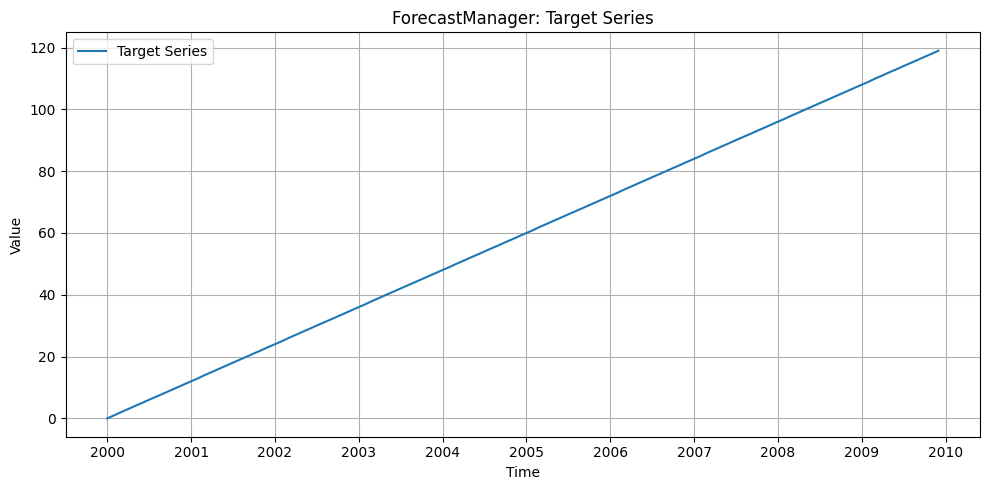

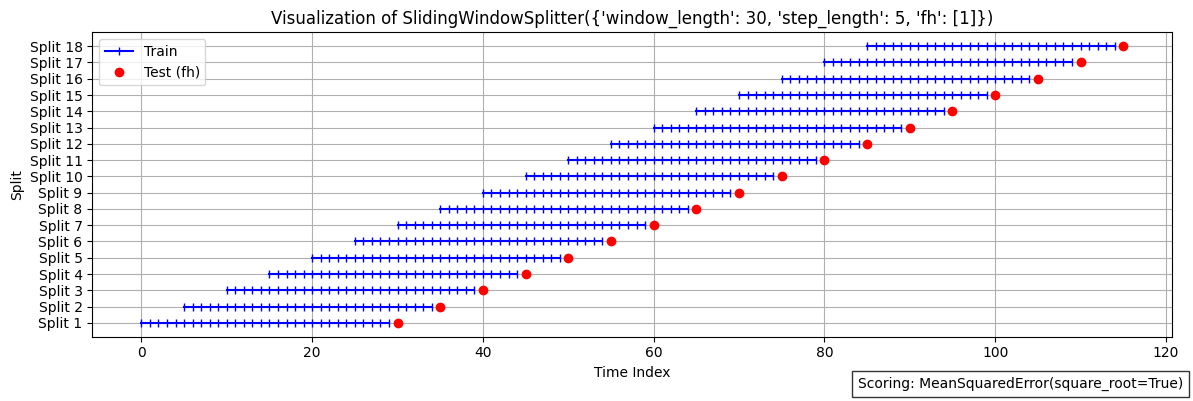

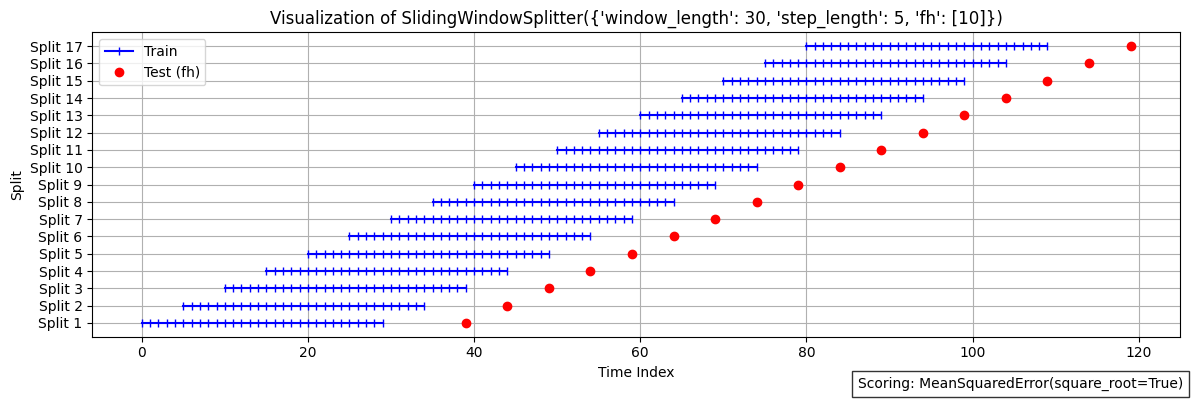

forecaster  \
                                                   forecaster_class   
NaiveForecaster({'strategy': 'last'})               NaiveForecaster   
NaiveForecaster({'strategy': 'mean'})               NaiveForecaster   
NaiveForecaster({'strategy': 'mean', 'window_le...  NaiveForecaster   

                                                                                              \
                                                                                 init_params   
NaiveForecaster({'strategy': 'last'})                                   {'strategy': 'last'}   
NaiveForecaster({'strategy': 'mean'})                                   {'strategy': 'mean'}   
NaiveForecaster({'strategy': 'mean', 'window_le...  {'strategy': 'mean', 'window_length': 6}   

                                                   SlidingWindowSplitter({'window_length': 30, 'step_length': 5, 'fh': [10]})  \
                                                                                                        test_MeanSquaredError   
NaiveForecaster({'strategy': 'last'})                                                             1.0                           
NaiveForecaster({'strategy': 'mean'})                                                            15.5                           
NaiveForecaster({'strategy': 'mean', 'window_le...                                                3.5                           

                                                   SlidingWindowSplitter({'window_length': 30, 'step_length': 5, 'fh': [1]})  
                                                                                                       test_MeanSquaredError  
NaiveForecaster({'strategy': 'last'})                                                            10.0                         
NaiveForecaster({'strategy': 'mean'})                                                            24.5                         
NaiveForecaster({'strategy': 'mean', 'window_le...                                               12.5

In [62]:
#################### Inputs #################################
forecaster_class_1 = NaiveForecaster
forecaster_class_2 = NaiveForecaster
forecaster_class_3 = NaiveForecaster
forecaster_class_4 = TransformedTargetForecaster
forecaster_class_5 = ExponentialSmoothing           # Holt-Winters
forecaster_class_6 = AutoARIMA


forecaster_params_1 = {
    'strategy':'last'
}

forecaster_params_2 = {
    'strategy':'mean',
    # 'window_length': 3
}

forecaster_params_3 = {
    'strategy':'mean',
    'window_length': 6
}

forecaster_params_4 = {
    'steps':[("deseasonalize", Deseasonalizer(model="additive", sp=12)),
    ("trend", PolynomialTrendForecaster(degree=1))]
}

forecaster_params_5 = {
    'trend': "add",
    'seasonal': "add",
    'sp': 12
}

forecaster_params_6 = {}


splitter_class_1 = SlidingWindowSplitter
splitter_class_2 = SlidingWindowSplitter
splitter_class_3 = SlidingWindowSplitter
splitter_class_4 = SlidingWindowSplitter

cv_params_1 = {'window_length':30, 'step_length': 5, 'fh': [1]}
cv_params_2 = {'window_length':30, 'step_length': 5, 'fh': [10]}
cv_params_3 = {'window_length':36, 'step_length': 7, 'fh': [6]}
cv_params_4 = {'window_length':36, 'step_length': 11, 'fh': [12]}

metric_1 = MeanSquaredError(square_root=True)
metric_2 = MeanSquaredError(square_root=True)
metric_3 = MeanSquaredError(square_root=True)
metric_4 = MeanSquaredError(square_root=True)

##############################################################

forecaster_1 = ManagedForecaster(forecaster_class=forecaster_class_1,init_params=forecaster_params_1)
forecaster_2 = ManagedForecaster(forecaster_class=forecaster_class_2,init_params=forecaster_params_2)
forecaster_3 = ManagedForecaster(forecaster_class=forecaster_class_3,init_params=forecaster_params_3)
forecaster_4 = ManagedForecaster(forecaster_class=forecaster_class_4,init_params=forecaster_params_4)
forecaster_5 = ManagedForecaster(forecaster_class=forecaster_class_5,init_params=forecaster_params_5)
# forecaster_6 = ManagedForecaster(forecaster_class=forecaster_class_6,init_params=forecaster_params_6)


managed_cv_1 = ManagedCrossValidator(splitter_class=splitter_class_1, init_params=cv_params_1)
managed_cv_2 = ManagedCrossValidator(splitter_class=splitter_class_2, init_params=cv_params_2)
managed_cv_3 = ManagedCrossValidator(splitter_class=splitter_class_3, init_params=cv_params_3)
managed_cv_4 = ManagedCrossValidator(splitter_class=splitter_class_4, init_params=cv_params_4)

managed_metric_1 = ManagedMetric(metric_1)
managed_metric_2 = ManagedMetric(metric_2)
managed_metric_3 = ManagedMetric(metric_3)
managed_metric_4 = ManagedMetric(metric_4)


managed_evaluator_1 = ManagedEvaluator(
    managed_cv = managed_cv_1,
    strategy="refit",
    scoring=managed_metric_1,
    error_score='raise')

managed_evaluator_2 = ManagedEvaluator(
    managed_cv = managed_cv_2,
    strategy="refit",
    scoring=managed_metric_2,
    error_score='raise')

managed_evaluator_3 = ManagedEvaluator(
    managed_cv = managed_cv_3,
    strategy="refit",
    scoring=managed_metric_3,
    error_score='raise')

managed_evaluator_4 = ManagedEvaluator(
    managed_cv = managed_cv_4,
    strategy="refit",
    scoring=managed_metric_4,
    error_score='raise')

fm = ForecastManager(y=ts)

fm.add_forecaster(forecaster_1)
fm.add_forecaster(forecaster_2)
fm.add_forecaster(forecaster_3)
# fm.add_forecaster(forecaster_4)
# fm.add_forecaster(forecaster_5)
# fm.add_forecaster(forecaster_6)

fm.add_evaluator(managed_evaluator_1)
fm.add_evaluator(managed_evaluator_2)
# fm.add_evaluator(managed_evaluator_3)
# fm.add_evaluator(managed_evaluator_4)

fm.evaluate()
# #fm.plot_all_evaluators()
fm.summarize_evaluations().to_csv('C:/Users/MichaelCrumley/OneDrive - tronair/code/PycharmProjects/items_forecast/data/evaluation_summary.csv')
# fm.summarize_evaluations()
fm.plot_series()
fm.plot_all_evaluators()
fm.summarize_evaluations()

In [51]:
# 19 folds

# errors on fold k:
#

0.10526315789473684